# Assignment 2 - Fitting Neural Networks  (v1)

## *Aspen Morgan*
Netid: 790907699

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Total points in the assignment add up to 80

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

# 1

## [60 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works).

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach, then retrain on the combined training and validation data before finally evaluating our generalization performance for our final model on the test data.

In [3]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

## Step 1: Create the data

In [4]:
def makeSincData(n,noise=0.03):
  # Define the grid of points
  x = np.random.uniform(-12,12,n)

  # Calculate the sinc function
  y = np.sinc(np.sqrt((x+6)**2))-np.sinc(np.sqrt((x-6)**2))+np.random.normal(0, noise, n)

  return (x,y)

# Number of samples
n = 150
noise = 0.03;

# Validation and test data
x_train,y_train = makeSincData(n, noise)
x_val,y_val = makeSincData(n, noise)
x_test,y_test = makeSincData(n, noise)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

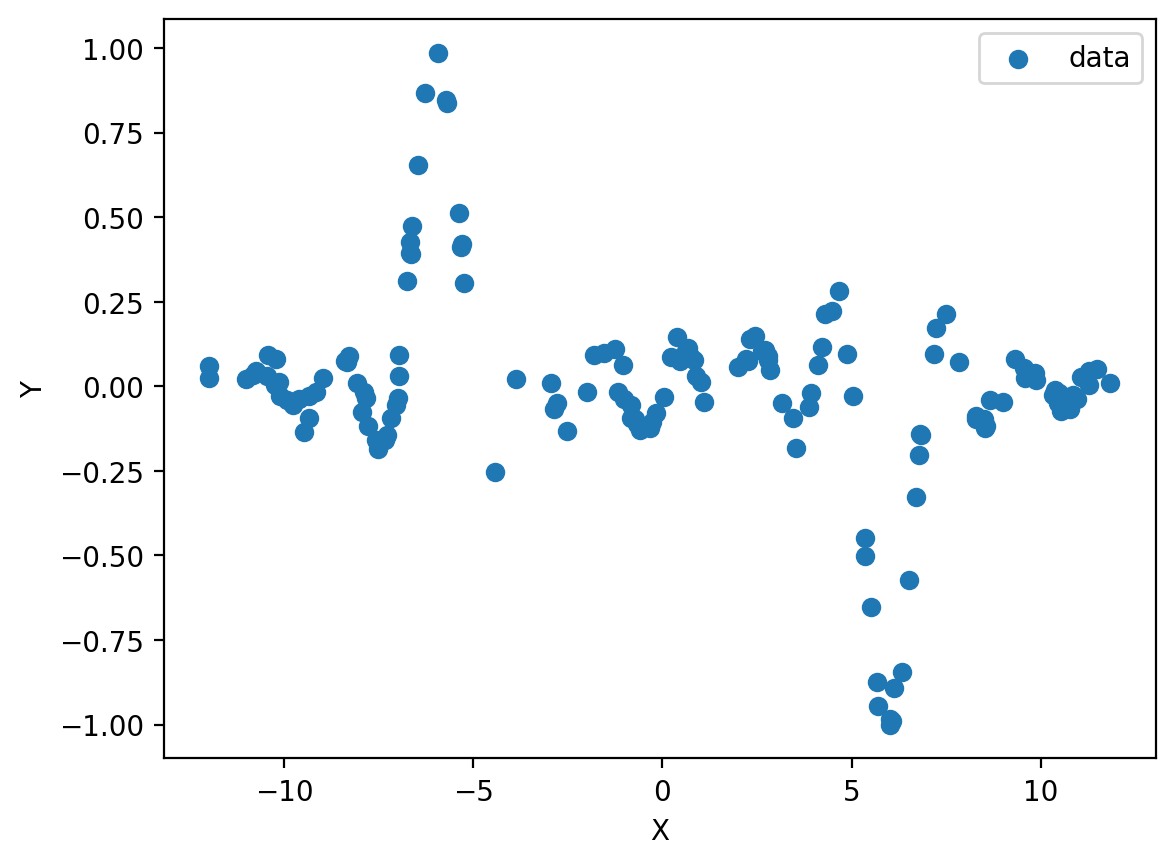

In [5]:
# Visualize the data
# Create the heatmap
plt.scatter(x_train,y_train)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['data'])
plt.show()

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (5,5) (two hidden layers, each with 5 nodes)
- `alpha` = 0 (regularization penalty - we have not discussed this in class yet)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 10 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the predictions made by your trained neural network; use 100 uniformly spaced x-values and pass them through your neural network to get y predictions.  Use these 100 $(x,y)$ pairs to create a line plot, and then on the same axes scatter plot the training data (note: you will need to train the model once for each parameter value, resulting in a separate plot for each trained model):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (10,10). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the batch size: 2, 5, 10

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=9&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,1&seed=0.50451&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=regression&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**ANSWER (a)**

In [6]:
# add empty bias term to x_train and to generated samples
x_train_df = pd.DataFrame({0: np.ones(len(x_train)), 1: x_train})
x_test_df = pd.DataFrame({0: np.ones(len(x_train)), 1: x_test})
x_samples = np.linspace(-12, 12, 100)
x_samples_df = pd.DataFrame({0: np.ones(len(x_samples)), 1: x_samples})

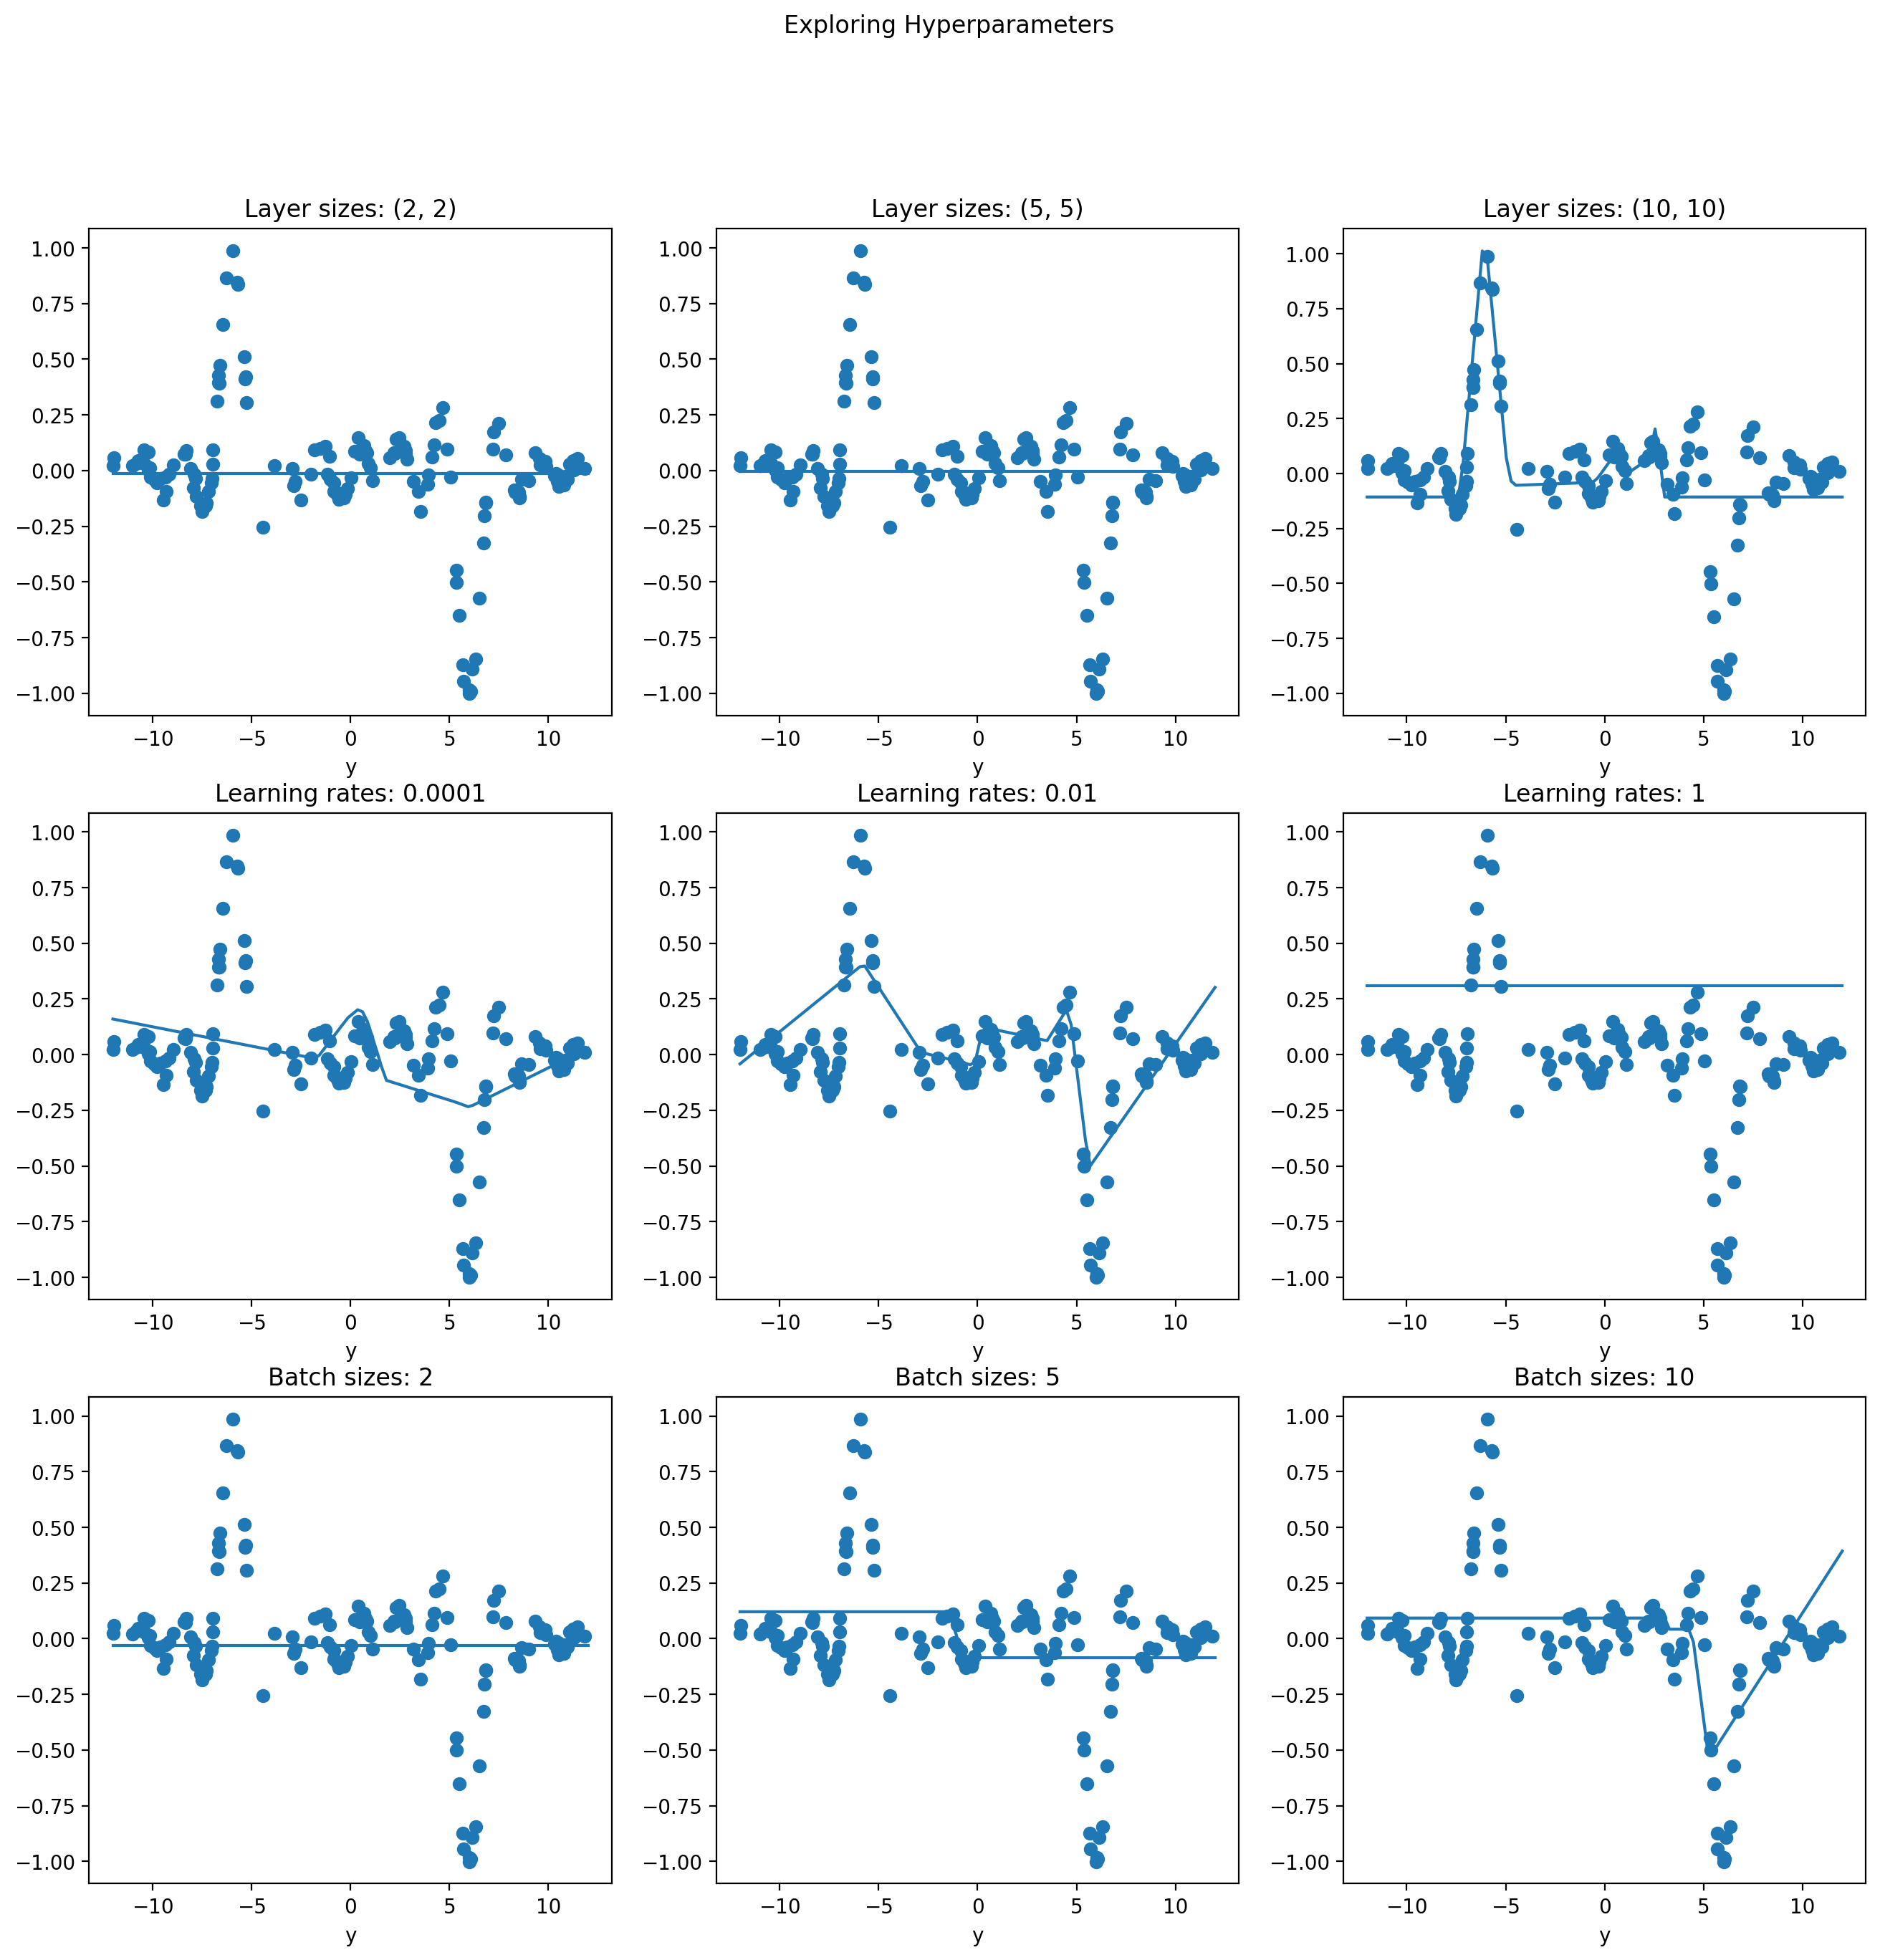

In [7]:
layer_sizes = [(2,2), (5,5), (10,10)]
learning_rates = [0.0001, 0.01, 1]
batch_sizes = [2, 5, 10]

fig, ax = plt.subplots(3, 3, figsize=(16,15))
for x in range(len(layer_sizes)):
    # set, fit, predict
    nn = MLPRegressor(learning_rate_init=0.03,
                      hidden_layer_sizes=layer_sizes[x],
                      alpha=0,
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=10,
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_train_pred = np.array((nn.predict(x_samples_df))).ravel()
    
    ax[0][x].plot(x_samples, y_train_pred, label='Predicted')
    ax[0][x].scatter(x_train, y_train, label='Training data')
    ax[0][x].set_title('Layer sizes: ' + str(layer_sizes[x]))
    ax[0][x].set_xlabel('x')
    ax[0][x].set_xlabel('y')
    
for x in range(len(learning_rates)):
    # set, fit, predict
    nn = MLPRegressor(learning_rate_init=learning_rates[x],
                      hidden_layer_sizes=(5,5),
                      alpha=0,
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=10,
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_train_pred = np.array((nn.predict(x_samples_df))).ravel()
    
    ax[1][x].plot(x_samples, y_train_pred, label='Predicted')
    ax[1][x].scatter(x_train, y_train, label='Training data')
    ax[1][x].set_title('Learning rates: ' + str(learning_rates[x]))
    ax[1][x].set_xlabel('x')
    ax[1][x].set_xlabel('y')
    
for x in range(len(batch_sizes)):
    # set, fit, predict
    nn = MLPRegressor(learning_rate_init=0.03,
                      hidden_layer_sizes=(5, 5),
                      alpha=0,
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=batch_sizes[x],
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_samples_pred = np.array((nn.predict(x_samples_df))).ravel()
    
    ax[2][x].plot(x_samples, y_samples_pred, label='Predicted')
    ax[2][x].scatter(x_train, y_train, label='Training data')
    ax[2][x].set_title('Batch sizes: ' + str(batch_sizes[x]))
    ax[2][x].set_xlabel('x')
    ax[2][x].set_xlabel('y')
    
fig.suptitle('Exploring Hyperparameters')
fig.show()

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset using mean-squared-error (MSE). Create plots of MSE vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**ANSWER (b)**

In [8]:
np.logspace(-8, 2, 20)

array([1.00000000e-08, 3.35981829e-08, 1.12883789e-07, 3.79269019e-07,
       1.27427499e-06, 4.28133240e-06, 1.43844989e-05, 4.83293024e-05,
       1.62377674e-04, 5.45559478e-04, 1.83298071e-03, 6.15848211e-03,
       2.06913808e-02, 6.95192796e-02, 2.33572147e-01, 7.84759970e-01,
       2.63665090e+00, 8.85866790e+00, 2.97635144e+01, 1.00000000e+02])

In [9]:
learning_rates = np.logspace(-5, 0, 20)
reg_params = np.logspace(-8, 2, 20)
batch_sizes = [1, 3, 5, 10, 20]

mse_lr, mse_regp, mse_bs = [], [], []

for x in range(len(learning_rates)):
    nn = MLPRegressor(learning_rate_init=learning_rates[x],
                      hidden_layer_sizes=(5,5),
                      alpha=0,
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=10,
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_test_pred = np.array((nn.predict(x_test_df))).ravel()
    mse_lr.append(mean_squared_error(y_test, y_test_pred))
    
for x in range(len(reg_params)):
    nn = MLPRegressor(learning_rate_init=0.03,
                      hidden_layer_sizes=(5,5),
                      alpha=reg_params[x],
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=10,
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_test_pred = np.array((nn.predict(x_test_df))).ravel()
    mse_regp.append(mean_squared_error(y_test, y_test_pred))
    
    
for x in range(len(batch_sizes)):
    nn = MLPRegressor(learning_rate_init=0.03,
                      hidden_layer_sizes=(5, 5),
                      alpha=0,
                      solver='sgd',
                      tol=1e-5,
                      early_stopping=False,
                      activation='relu',
                      n_iter_no_change=1000,
                      batch_size=batch_sizes[x],
                      max_iter=500)
    nn.fit(x_train_df, y_train.ravel())
    y_train_pred = np.array((nn.predict(x_samples_df))).ravel()
    y_test_pred = np.array((nn.predict(x_test_df))).ravel()
    mse_bs.append(mean_squared_error(y_test, y_test_pred))

In [17]:
reg_params[np.where(reg_params>=1)[0][0]:]

array([  2.6366509 ,   8.8586679 ,  29.76351442, 100.        ])

Text(0, 0.5, 'Validation MSE')

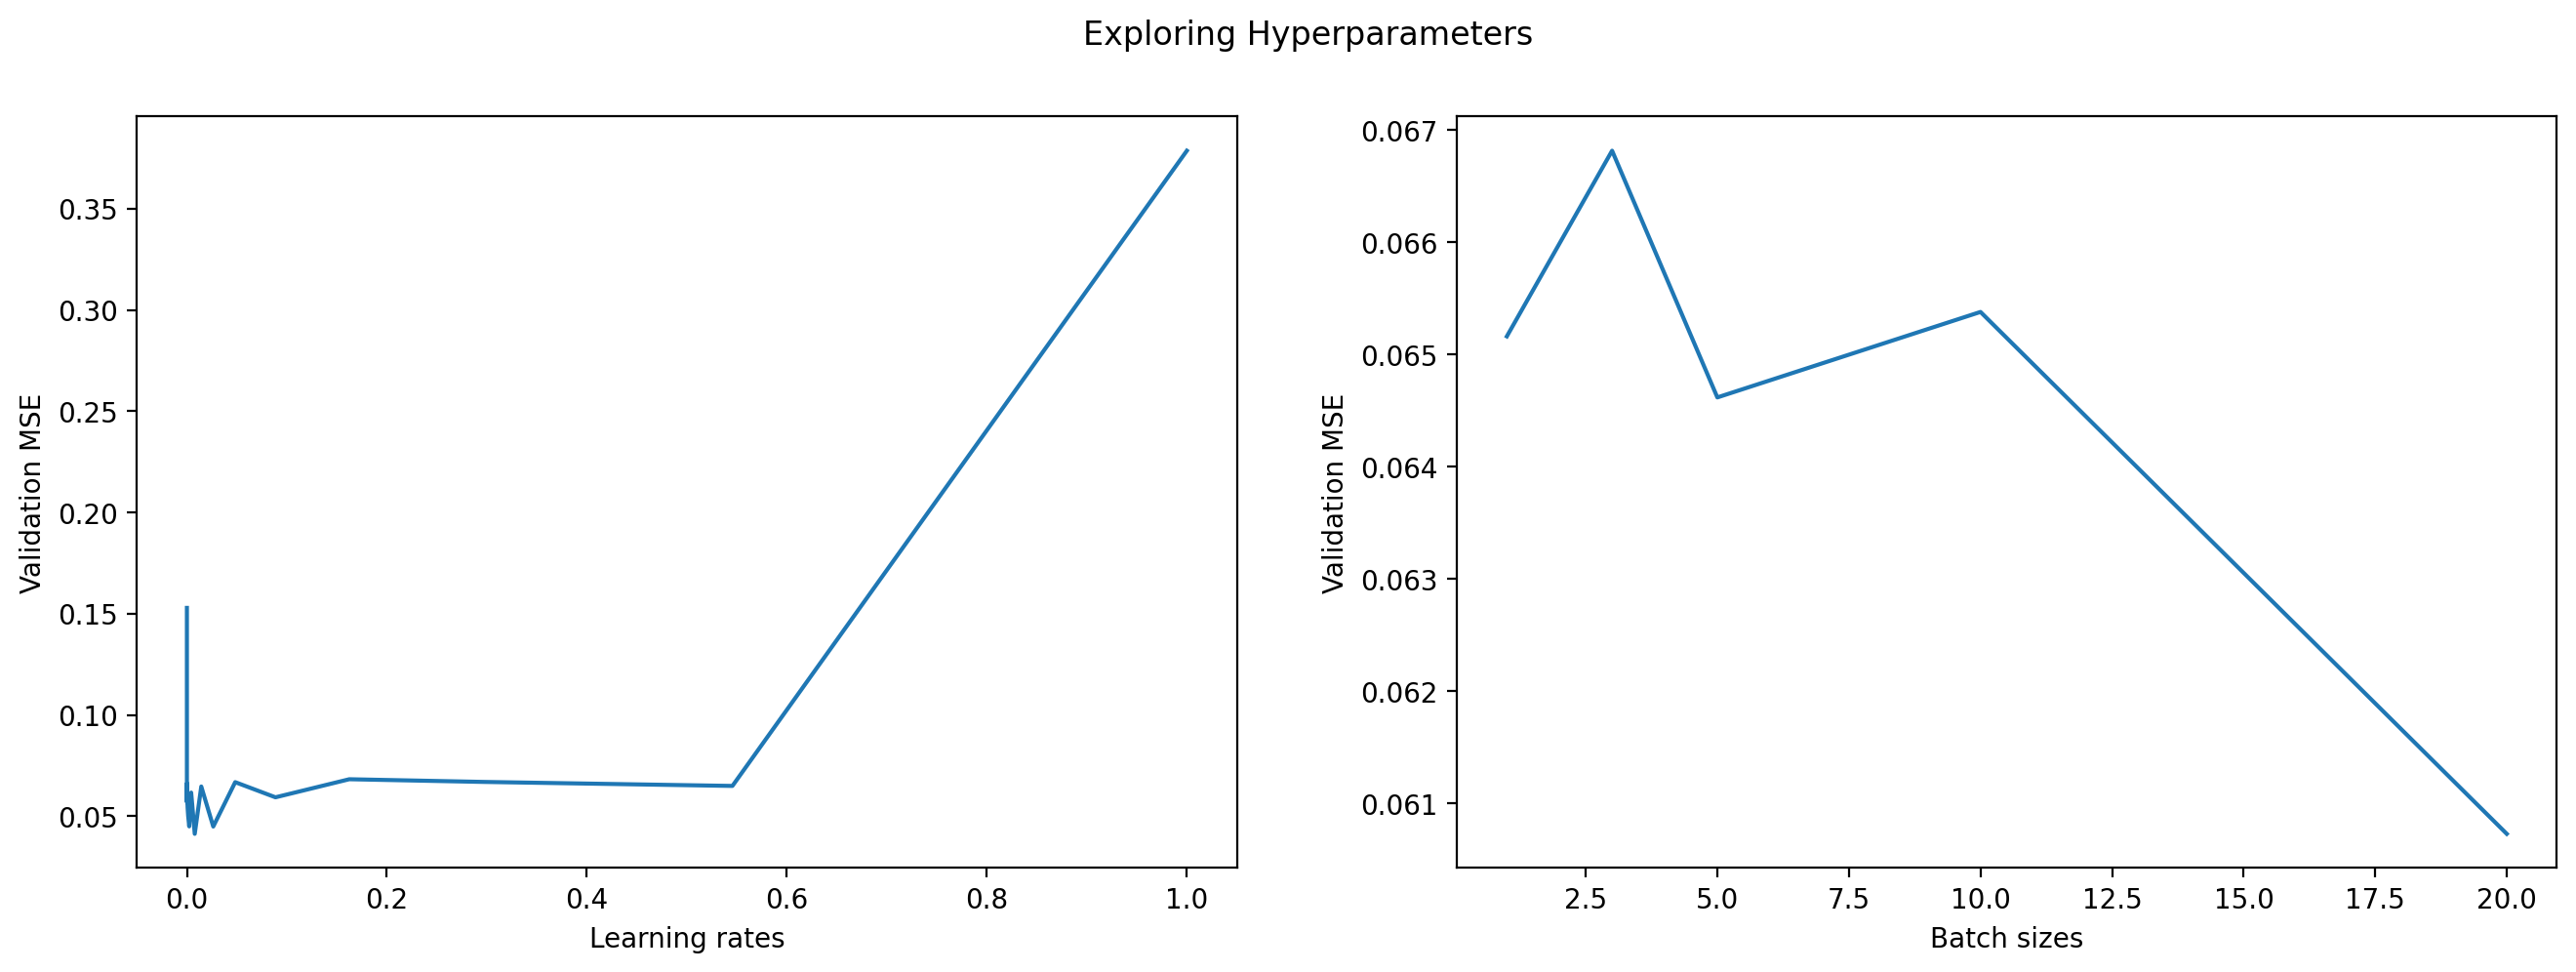

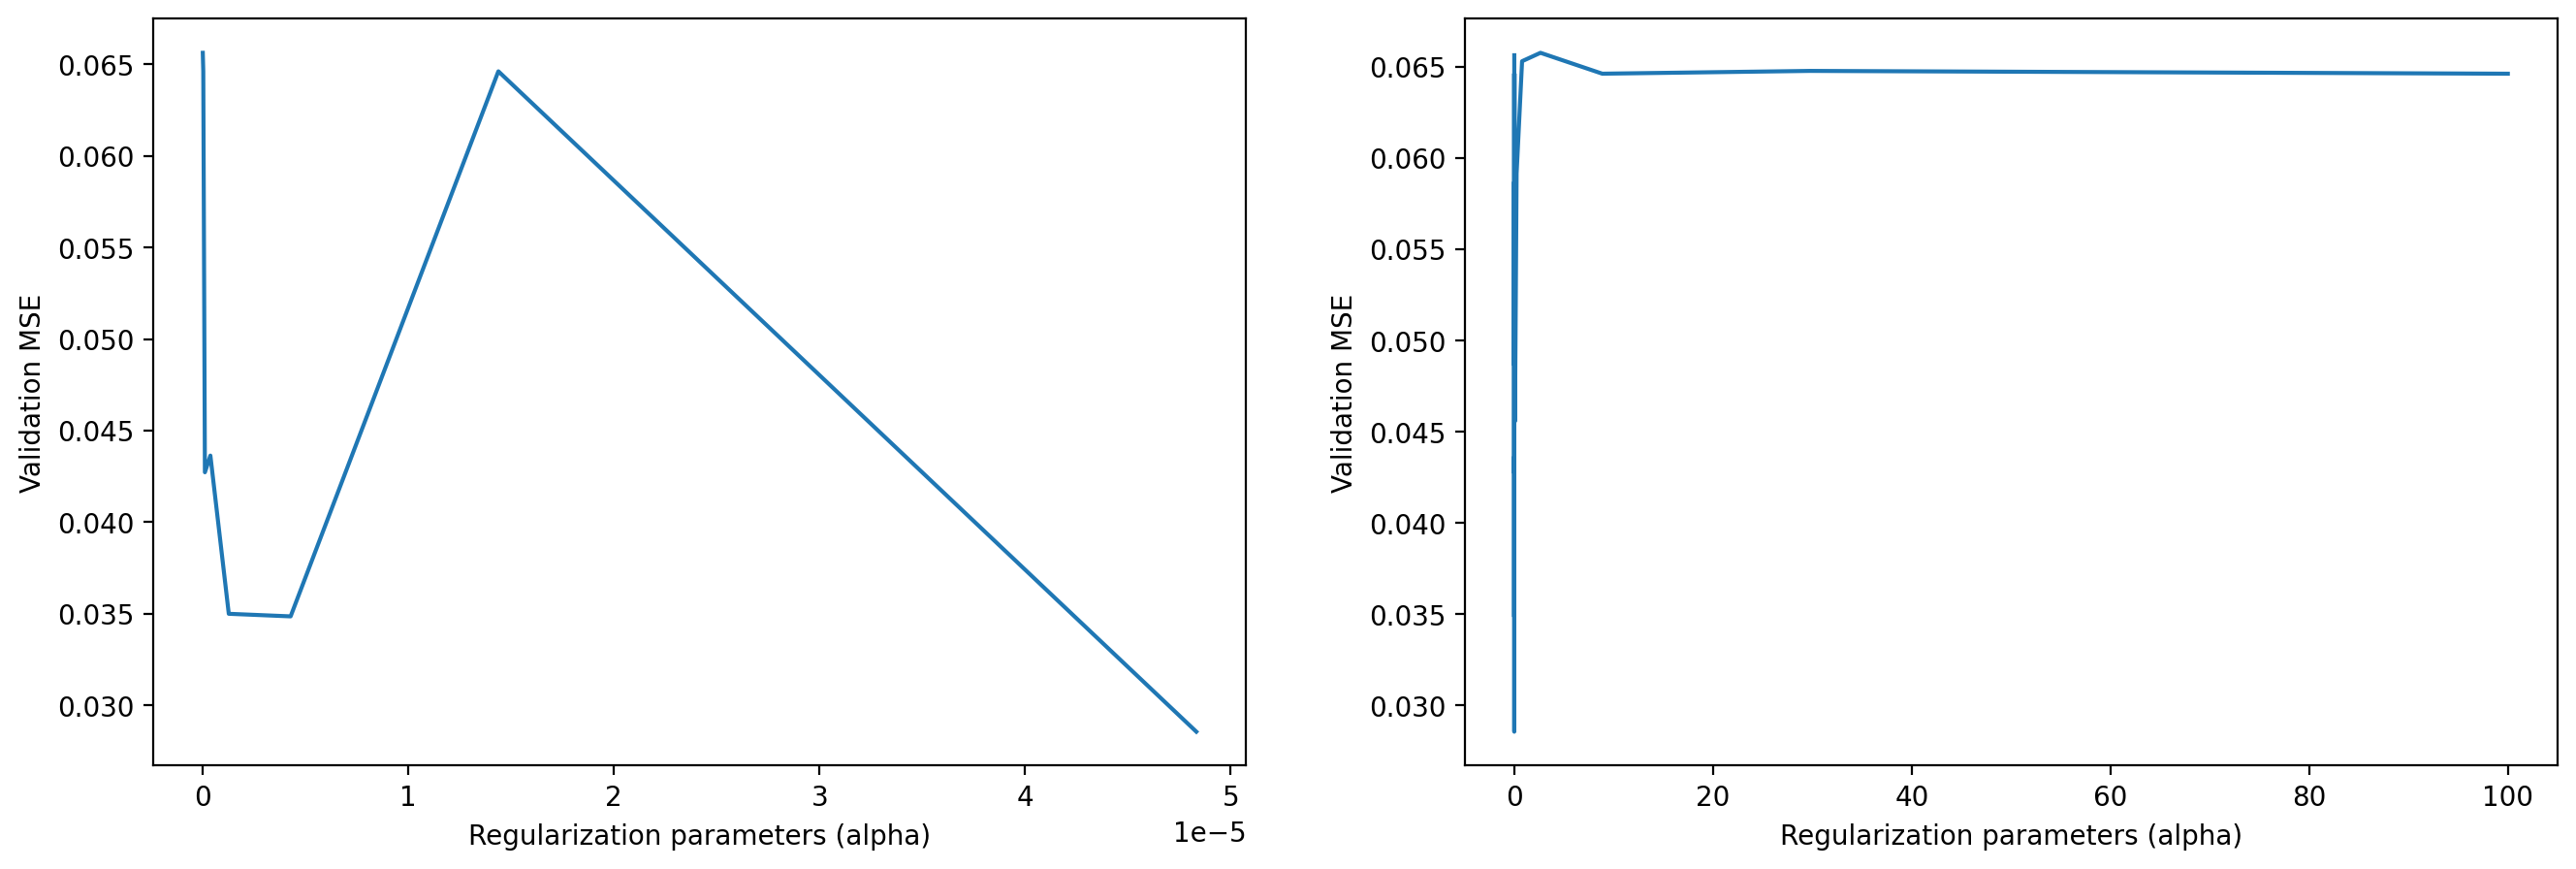

In [24]:
# plot results   
fig, ax = plt.subplots(1, 2, figsize=(16,5))   
fig.suptitle('Exploring Hyperparameters')
ax[0].plot(learning_rates, mse_lr)
ax[0].set_xlabel('Learning rates')
ax[0].set_ylabel('Validation MSE')
ax[1].plot(batch_sizes, mse_bs)
ax[1].set_xlabel('Batch sizes')
ax[1].set_ylabel('Validation MSE')

fig, ax = plt.subplots(1, 2, figsize=(16,5)) 
ax[0].plot(reg_params[:np.where(reg_params>=1e-4)[0][0]], mse_regp[:np.where(reg_params>=1e-4)[0][0]])
ax[0].set_xlabel('Regularization parameters (alpha)')
ax[0].set_ylabel('Validation MSE')
ax[1].plot(reg_params, mse_regp)
ax[1].set_xlabel('Regularization parameters (alpha)')
ax[1].set_ylabel('Validation MSE')

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the MSE resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (10,10) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b).
- Number of nodes per layer: $[1,2,3,4,5,10]$
- Number of layers = $[1,2,3,4]$
Report the MSE of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of MSE in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to at least **6 decimal places**.

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred).
- What do the results show? Which parameters did you select and why?

**ANSWER (c)**

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`).
- Apply the trained model to the test data and report the accuracy of your final model on the test data, in terms of MSE
- Scatter plot the test data and make a line plot using 100 sampled predictions from your model over the $x$-domain of your test data

**ANSWER (d)**

# 2

## [20 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a)** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit` and `predict`. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible).
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: if you choose not to build your own neural network, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead**

**(b)** Apply your neural network.
- Utilize the training and validation datasets from problem 1
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time).
- Tune the learning rate and number of training epochs for your model to improve performance as needed.
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the predictions from your neural network as well as a Scikit MLPRegressor trained with the exact same parameters.  Use the strategy from problem 1 for plotting a trained model (e.g., create 100 uniformly spaced $x$ values and pass them through the models). Use different colors for your model and the scikit model, and make sure to include a legend on each of your subplots.
- Report the MSE of your trained MLP and the scikit-learn MLP, respectively. Are they the same, very similar, or very different?  Why?

In [ ]:
class myNeuralNetwork(object):

    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''

    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''

    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''

    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss functionof the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''

    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step [OPTIONAL - you may also do this
        directly in backpropagate]
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.

        Input: none
        Output: none
        '''

    def fit(self, X, y, max_epochs=, learning_rate=, get_validation_loss=):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''

    def predict(self, X, decision_thresh=):
        '''predict
        Compute the output of the neural network prediction for
        each sample in X
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of predictions [N x 1]
        '''